In [2]:
#!/usr/bin/env python
import cv2
import numpy as np
from matplotlib import pyplot as plt

SZ = 20
CLASS_N = 10

# local modules
from common import clock, mosaic

In [3]:
def split2d(img, cell_size, flatten=True):
    h, w = img.shape[:2]
    sx, sy = cell_size
    cells = [np.hsplit(row, w//sx) for row in np.vsplit(img, h//sy)]
    cells = np.array(cells)
    if flatten:
        cells = cells.reshape(-1, sy, sx)
    return cells

In [4]:

def load_digits(fn):
    digits_img = cv2.imread(fn, 0)
    digits = split2d(digits_img, (SZ, SZ))
    labels = np.repeat(np.arange(CLASS_N), len(digits)/CLASS_N)
    return digits, labels

def deskew(img):
    m = cv2.moments(img)
    if abs(m['mu02']) < 1e-2:
        return img.copy()
    skew = m['mu11']/m['mu02']
    M = np.float32([[1, skew, -0.5*SZ*skew], [0, 1, 0]])
    img = cv2.warpAffine(img, M, (SZ, SZ), flags=cv2.WARP_INVERSE_MAP | cv2.INTER_LINEAR)
    return img

def svmInit(C=12.5, gamma=0.50625):
    model = cv2.ml.SVM_create()
    model.setGamma(gamma)
    model.setC(C)
    model.setKernel(cv2.ml.SVM_RBF)
    model.setType(cv2.ml.SVM_C_SVC)
    return model

def svmTrain(model, samples, responses):
    model.train(samples, cv2.ml.ROW_SAMPLE, responses)
    return model

def svmPredict(model, samples):
    return model.predict(samples)[1].ravel()

def svmEvaluate(model, digits, samples, labels):
    predictions = svmPredict(model, samples)
    accuracy = (labels == predictions).mean()
    print('Percentage Accuracy: %.2f %%' % (accuracy*100))

    confusion = np.zeros((10, 10), np.int32)
    for i, j in zip(labels, predictions):
        confusion[int(i), int(j)] += 1
    print('confusion matrix:')
    print(confusion)

    vis = []
    for img, flag in zip(digits, predictions == labels):
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        if not flag:
            img[...,:2] = 0
        
        vis.append(img)
    return mosaic(25, vis)


def preprocess_simple(digits):
    return np.float32(digits).reshape(-1, SZ*SZ) / 255.0


def get_hog() : 
    winSize = (20,20)
    blockSize = (8,8)
    blockStride = (4,4)
    cellSize = (8,8)
    nbins = 9
    derivAperture = 1
    winSigma = -1.
    histogramNormType = 0
    L2HysThreshold = 0.2
    gammaCorrection = 1
    nlevels = 64
    signedGradient = True

    hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,histogramNormType,L2HysThreshold,gammaCorrection,nlevels, signedGradient)

    return hog
    affine_flags = cv2.WARP_INVERSE_MAP|cv2.INTER_LINEAR

Loading digits from digits.png ... 
Shuffle data ... 
Deskew images ... 
Defining HoG parameters ...
Calculating HoG descriptor for every image ... 
Spliting data into training (90%) and test set (10%)... 
Training SVM model ...
Evaluating model ... 
Percentage Accuracy: 99.00 %
confusion matrix:
[[52  0  0  0  0  0  0  0  0  0]
 [ 0 43  2  0  0  0  0  0  0  0]
 [ 0  0 61  0  0  0  0  1  0  0]
 [ 0  0  0 49  0  0  0  0  0  0]
 [ 0  0  0  0 44  0  0  0  0  0]
 [ 0  0  0  0  0 49  0  0  0  0]
 [ 0  0  0  0  0  0 46  0  0  0]
 [ 0  0  0  0  0  0  0 50  1  0]
 [ 0  0  0  0  0  1  0  0 50  0]
 [ 0  0  0  0  0  0  0  0  0 51]]


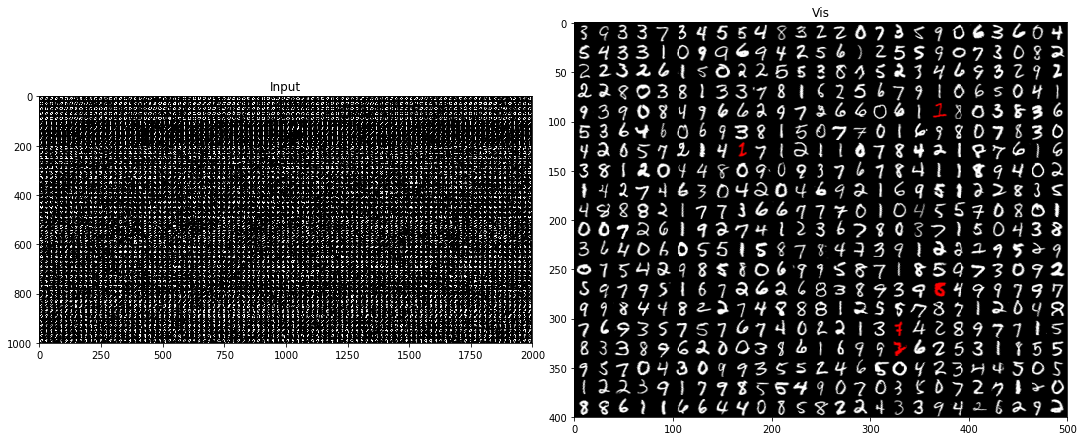

In [5]:
if __name__ == '__main__':

    print('Loading digits from digits.png ... ')
    # Load data.
    image = cv2.imread('digits.png')
    digits, labels = load_digits('digits.png')

    print('Shuffle data ... ')
    # Shuffle data
    rand = np.random.RandomState(10)
    shuffle = rand.permutation(len(digits))
    digits, labels = digits[shuffle], labels[shuffle]
    
    print('Deskew images ... ')
    digits_deskewed = list(map(deskew, digits))
    
    print('Defining HoG parameters ...')
    # HoG feature descriptor
    hog = get_hog();

    print('Calculating HoG descriptor for every image ... ')
    hog_descriptors = []
    for img in digits_deskewed:
        hog_descriptors.append(hog.compute(img))
    hog_descriptors = np.squeeze(hog_descriptors)

    print('Spliting data into training (90%) and test set (10%)... ')
    train_n=int(0.9*len(hog_descriptors))
    digits_train, digits_test = np.split(digits_deskewed, [train_n])
    hog_descriptors_train, hog_descriptors_test = np.split(hog_descriptors, [train_n])
    labels_train, labels_test = np.split(labels, [train_n])
    
    
    print('Training SVM model ...')
    model = svmInit()
    svmTrain(model, hog_descriptors_train, labels_train)

    print('Evaluating model ... ')
    vis = svmEvaluate(model, digits_test, hog_descriptors_test, labels_test)

    row, col = 1, 2
    fig, axs = plt.subplots(row, col, figsize=(15, 10))
    fig.tight_layout()

    axs[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[0].set_title('Input')
    cv2.imwrite('Input.jpg', image)

    axs[1].imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
    axs[1].set_title('Vis')
    cv2.imwrite('digits_classification.jpg', vis)

    plt.show()